## Autoencoders with Keras, TensorFlow

The original blog and codes can be reached from https://pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/?_ga=2.59518829.1725668903.1675464178-1130789896.1638882117. Images are also taken from that blog.

This notebook is just a exercise of this blog and a reminder what autoencoders are. 



First and the most important note is: 

    !! AUTOENCODERS ARE UNSUPERVISED !!!! 
    
We don't need labels. 

And the second is: 

    !! U SHAPED MODEL !!! 
    
this is why we create two cnn models which are mirrorred

This image is a good review about How autoencoders work : 

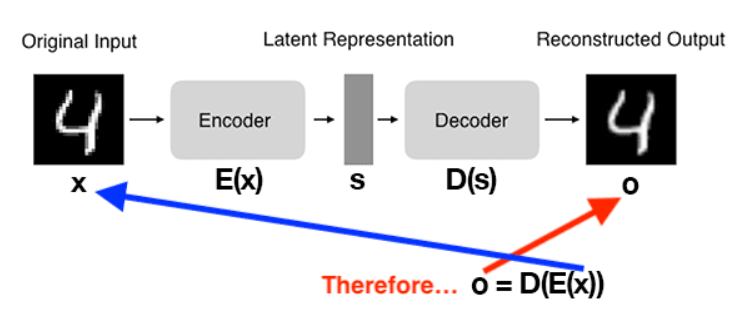

To train an autoencoder, we input our data, attempt to reconstruct it, and then minimize the mean squared error (or similar loss function).

Ideally, the output of the autoencoder will be near identical to the input.

we’ll be training an autoencoder on the MNIST dataset. The MNIST dataset consists of digits that are 28×28 pixels with a single channel, implying that each digit is represented by 28 x 28 = 784 values. The autoencoder we’ll be training here will be able to compress those digits into a vector of only 16 values — that’s a reduction of nearly 98%!

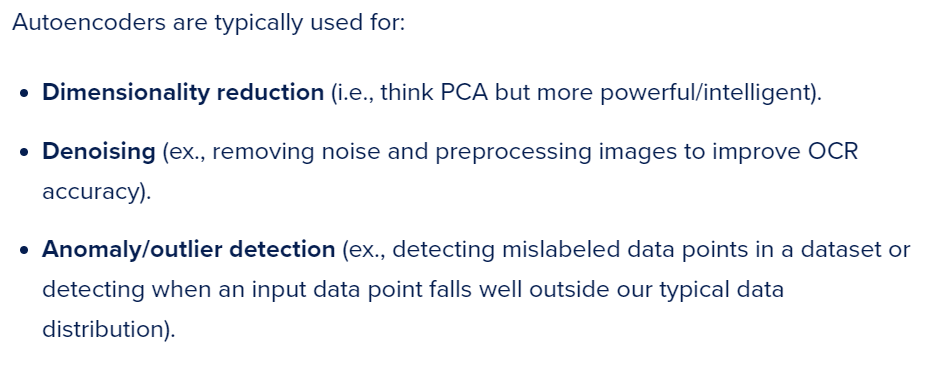

Let's create our 'CNN' ENCODER step by step...

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

In [2]:
# our model will train on mnist dataset. because of that dimensions of input 
inputShape = (28, 28, 1)

#channel is at the end
chanDim = -1

#our latent representation will be 16 dims
latentDim=16

In [3]:
inputs = Input(shape=inputShape)
x = inputs
#first Conv layer 32 filters
x = Conv2D(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)
#second Conv layer 64 filters
x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

In [4]:
# flatten the network and then construct our latent vector
volumeSize = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latentDim)(x)

# build the encoder model
encoder = Model(inputs, latent, name="encoder")

In [5]:
print(volumeSize) # need for decoders
print(latent)

(None, 7, 7, 64)
KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")


In [6]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                           

In [7]:
from PIL import Image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

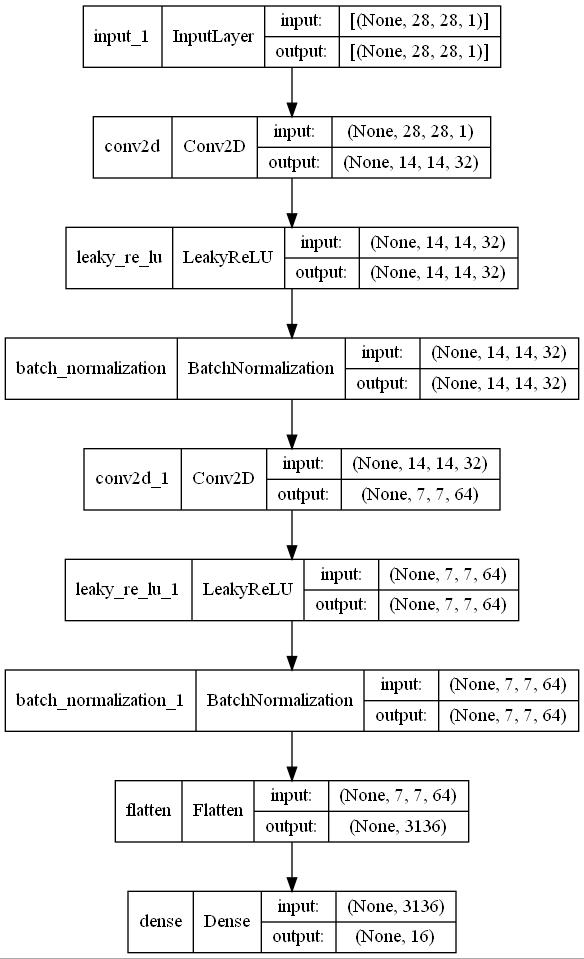

In [8]:
plot_model(encoder, show_shapes=True, show_layer_names=True, to_file='encoder.jpg')

 NOW WE NEED OUR DECODER... WE WILL CREATE DECODER LIKE ENCODER BUT WITH TRANSPOSECONV 
 

In [12]:
#output of encoder will be our input for decoder
latentInputs = Input(shape=(latentDim,))
#np.prod Return the product of array elements over a given axis.
a=np.prod([7,7,64])
print(a)



3136


In [13]:
x = Dense(np.prod(volumeSize[1:]))(latentInputs)


In [14]:
x

<KerasTensor: shape=(None, 3136) dtype=float32 (created by layer 'dense_1')>

In [15]:
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

In [16]:
x

<KerasTensor: shape=(None, 7, 7, 64) dtype=float32 (created by layer 'reshape')>

In [17]:
#transpose conv for reverse 
x = Conv2DTranspose(64, (3, 3), strides=2,padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)
x = Conv2DTranspose(32, (3, 3), strides=2,padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

In [18]:
#apply a single CONV_TRANSPOSE layer used to recover the original shape
x = Conv2DTranspose(1, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)

In [19]:
x

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_transpose_2')>

In [20]:
outputs

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'activation')>

In [21]:
# build the decoder model
decoder = Model(latentInputs, outputs, name="decoder")

In [22]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                           

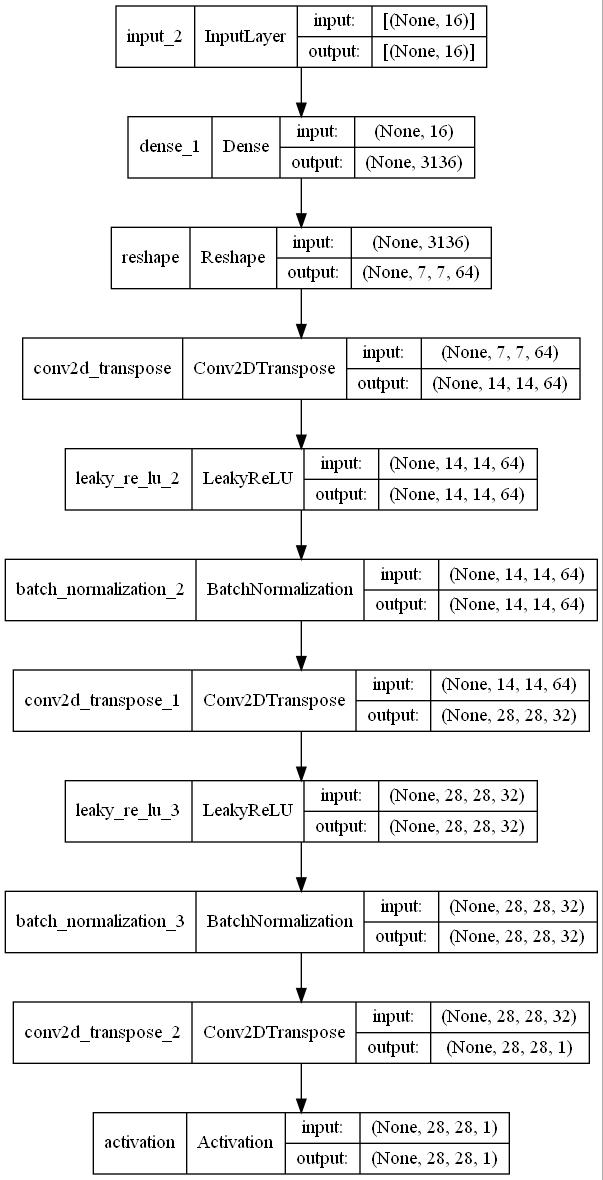

In [23]:
plot_model(decoder, show_shapes=True, show_layer_names=True, to_file='decoder.jpg')

WE CREATED BOTH ENCODER AND DECODER... NOW WE WILL COMBINE THEM AND MAKE A ONE MODEL AS OUR 'AUTOENCODER'

In [24]:
# our autoencoder is the encoder + decoder
autoencoder = Model(inputs, decoder(encoder(inputs)),name="autoencoder")

In [25]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69392     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         109377    
                                                                 
Total params: 178,769
Trainable params: 178,385
Non-trainable params: 384
_________________________________________________________________


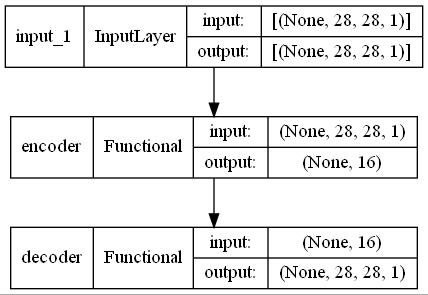

In [26]:
plot_model(autoencoder, show_shapes=True, show_layer_names=True, to_file='autoencoder.jpg')

Let's prepare our dataset and fit our model

In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

In [29]:
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

[INFO] loading MNIST dataset...


We don't need labels for our model, because autoencoders are unsupervised models

In [30]:
#adding channel for model and normalize images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

In [32]:
EPOCHS = 25
BS = 32
opt = Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

In [33]:
# train the convolutional autoencoder
H = autoencoder.fit(trainX, trainX,validation_data=(testX, testX),epochs=EPOCHS,batch_size=BS)

Epoch 1/25
1875/1875 [==============================] - 26s 8ms/step - loss: 0.0181 - val_loss: 0.0106
Epoch 2/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0102 - val_loss: 0.0096
Epoch 3/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 4/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0087 - val_loss: 0.0087
Epoch 5/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 6/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0080 - val_loss: 0.0082
Epoch 7/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 8/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 9/25
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 10/25
1875/1875 [==============================] - 15s 8ms/step - l

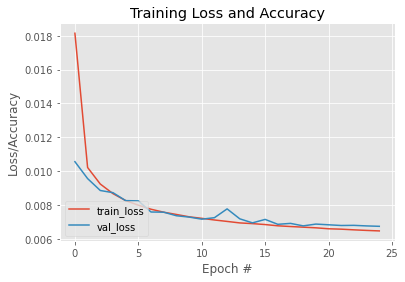

In [34]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('training_autoencoder.png')

In [36]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
outputs = None

# loop over our number of output samples
for i in range(0,8):
# grab the original image and reconstructed image
    original = (testX[i] * 255).astype("uint8")
    recon = (decoded[i] * 255).astype("uint8")

# stack the original and reconstructed image side-by-side
    output = np.hstack([original, recon])

# if the outputs array is empty, initialize it as the current
# side-by-side image display
    if outputs is None:
        outputs = output

        # otherwise, vertically stack the outputs
    else:
        outputs = np.vstack([outputs, output])

# save the outputs image to disk
cv2.imwrite('results.png', outputs)

[INFO] making predictions...


True

result.png looks like :

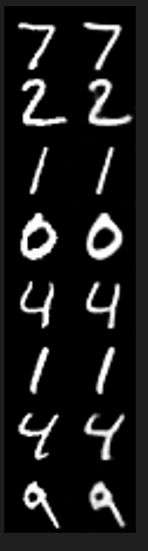

In [38]:
decoded.shape

(10000, 28, 28, 1)

Our testset has 10000 images... because of that decoded array also has 10000 28x28x1 images !!!

In [39]:
autoencoder.save('mnist_autoencoder.hdf5')

FOR MORE ENCODER EXAMPLE :

https://blog.keras.io/building-autoencoders-in-keras.html